# OdC's 2025 NDVI Geovisor

This notebook loads each city's NDVI data, processes and __creates the .htmls needed for kepler visualization.__

* __Important note: Worked fine with keplergl v0.3.2, but not with kepler v.0.3.7.__
* __Final parameters used for NDVI Visor:__
  * __res__: 10
  * __filter_urban__: True
  * __dissolve_hexs__: False
  * __calculate_slope__: False
  * __palette__: palette_2025
  * __stroke__: 0.05, white
  * __opacity__: 0.10

In [1]:
# NDVI 2023 OdC's publication (White background)
# Suelo artificial: "#c6c6c6" (Light grey)
# Suelo: "#edf0d8" (Cream)
# Vegetación mínima: "#add767" (Light green)
# Vegetación moderada: "#1c934f" (Green)
# Vegetación máxima: "#004428" (Dark green)

# OdC's 2025 NDVI Geovisor (Altered in order to work with both dark basemap and satellite basemap) [palette_2025]
# Suelo artificial: "#939393" (Semi-dark gray)
# Vegetación escasa: "#e9f6d0" (Very light green)
# Vegetación moderada: "#add767" (Light green)
# Vegetación densa: "#1c934f" (Green)
# Vegetación muy densa: "#004428" (Dark green)

## __Import libraries__

In [2]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/jovyan/accesibilidad-urbana


In [3]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

# Imports que venían en el Notebook 15-min-city > 13-15-min-kepler-test.ipynb
import io
#import boto3
from keplergl import KeplerGl

# Add slope visualization as a new layer to be visualized in the config dict [Canceled]
import copy

# Correlation calc
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## __Config notebook__

In [4]:
# Set test True (runs specified city_lst) or False (runs all available cities)
test = False
if test == True:
    city_lst = ['Aguascalientes'] # Gets overwritten if test = False
    res = 8
else:
    res = 10

projected_crs = 'EPSG:6372'
# Processing - Filter for urban areas only?
filter_urban = True
# Processing - If running CDMX (capital city), add ZMVM (metropolitan area)
merge_capital = True
# Output - Dissolve hexs by NDVI Category?
dissolve_hexs = False #If true, cannot add ndvi slope data
# Output - Add slope data? (Only works if dissolve_hexs is false)
slope_data = False

# Directory where .html files are saved
map_output_dir = str(project_root) + f"/data/processed/visor_ndvi/"

In [5]:
# Slope function
def calc_slope(row, cols):
    data = row[cols].astype(float).values
    slope, intercept = np.polyfit(years, data, 1)
    return slope

## __Processing__

### __Processing__: Find all available cities
##### (If test = False, substitutes city_list with all cities available in db)

In [6]:
if test == False:
    # Find all available cities
    ndvi_schema = 'raster_analysis'
    ndvi_table = 'ndvi_analysis_hex'
    scan_res = 8
    query = f"SELECT city FROM {ndvi_schema}.{ndvi_table} WHERE \"res\" = '{scan_res}\'"
    ndvi_df = aup.df_from_query(query)
    city_lst = list(ndvi_df.city.unique())

# If merge_capital, drop ZMVM in order to load ZMVM when loading CDMX during processing.
if merge_capital and ('CDMX' in city_lst) and ('ZMVM' in city_lst):
    city_lst.remove('ZMVM')

print(f"{len(city_lst)} cities to run at res {res}.")
city_lst

48 cities to run at res 10.


['Acapulco',
 'Aguascalientes',
 'CDMX',
 'Chihuahua',
 'Chilpancingo',
 'Ciudad Obregon',
 'Colima',
 'Cuautla',
 'Cuernavaca',
 'Delicias',
 'Durango',
 'Ensenada',
 'Guadalajara',
 'Hermosillo',
 'Juarez',
 'Laguna',
 'La Paz',
 'Los Cabos',
 'Los Mochis',
 'Matamoros',
 'Mazatlan',
 'Mexicali',
 'Monclova',
 'Monterrey',
 'Nogales',
 'Nuevo Laredo',
 'Oaxaca',
 'Pachuca',
 'Piedras Negras',
 'Poza Rica',
 'Puebla',
 'Queretaro',
 'Reynosa',
 'San Martin',
 'Tapachula',
 'Tehuacan',
 'Tepic',
 'Tijuana',
 'Tlaxcala',
 'Toluca',
 'Tulancingo',
 'Uruapan',
 'Vallarta',
 'Victoria',
 'Villahermosa',
 'Xalapa',
 'Zacatecas',
 'Zamora']

### __Processing__: Create Kepler HTMLs files by city

In [7]:
i=0
for city in city_lst:

    try:
        print("--"*30)
        print(f"--- STARTING CITY {i}/{len(city_lst)}: {city}.")
    
        # 1.0 --- --- --- LOAD DATA --- --- ---
        
        # 1.1 --- LOAD URBAN HEXS
        print(f"Loading {city}'s urban hexs.")
        # Load data
        hex_schema = 'hexgrid'
        hex_table = f'hexgrid_{res}_city_2020'
        # Load city's hexs filtering for urban areas if required
        if filter_urban:
            hex_type = 'urban'
            query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\' AND \"type\" = '{hex_type}\'"
        else:
            query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\'"
        hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
        
        # SPECIFIC CASE - Merge capital's hexs (CDMX + ZMVM)
        if merge_capital and (city == 'CDMX'):
            print("MERGING CDMX + ZMVM hexs.")
            # Load ZMVM's hexs filtering for urban areas if required
            if filter_urban:
                hex_type = 'urban'
                query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = 'ZMVM\' AND \"type\" = '{hex_type}\'"
            else:
                query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = 'ZMVM\'"
            metro_hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
            # Merge CDMX and ZMVM hexs
            hex_gdf = pd.concat([hex_gdf,metro_hex_gdf])
            
        # Read and format cols
        hex_gdf['res'] = res
        hex_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
        hex_gdf.to_crs(projected_crs,inplace=True)
        # List all unique hex_ids
        hexid_lst = list(hex_gdf.hex_id.unique())
        del hex_gdf
        
        # 1.2 --- LOAD NDVI DATA
        print(f"Loading {city}'s NDVI data.")
        ndvi_schema = 'raster_analysis'
        ndvi_table = 'ndvi_analysis_hex'
        query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
        ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

        # SPECIFIC CASE - Merge capital's NDVI (CDMX + ZMVM)
        if merge_capital and (city == 'CDMX'):
            print("MERGING CDMX + ZMVM NDVI.")
            # Load metro area's NDVI
            query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" = 'ZMVM\' AND \"res\" = '{res}\'"
            metro_ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
            # Merge capital and metro area hexs
            ndvi_gdf = pd.concat([ndvi_gdf,metro_ndvi_gdf])
            # Drop duplicated hexs (Both in CDMX and ZMVM)
            ndvi_gdf.drop_duplicates(subset="hex_id", 
                                     inplace=True)

        # 1.3 --- FORMAT NDVI DATA
        ndvi_gdf.to_crs(projected_crs,inplace=True)
        # Filter for urban areas if required
        if filter_urban:
            ndvi_gdf = ndvi_gdf.loc[ndvi_gdf.hex_id.isin(hexid_lst)].copy()
        # Inf values check
        infs = ndvi_gdf.loc[np.isinf(ndvi_gdf['ndvi_mean'])]
        if len(infs)>0:
            print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
            ndvi_gdf = ndvi_gdf.loc[~np.isinf(ndvi_gdf['ndvi_mean'])].copy()
        
        # 2.0 --- --- --- CALCULATIONS AND DATA TREATMENT --- --- ---
        # If dissolve_hexs, dissolves hexs by NDVI categories and does not calculate slope.
        # If not dissolve_hexs, can add slope.

        # 2.1 --- CALCULATE NDVI CATEGORIES AND PREPARE GDF FOR KEPLER CONFIGURATION
        print(f"Creating {city}'s vegetation categories and preparing hex_kepler.")
        ndvi_categories = ['5. Suelo artificial/agua', '4. Vegetación escasa', '3. Vegetación moderada', '2. Vegetación densa', '1. Vegetación muy densa']
        #original_ndvi_categories = ['Suelo artificial/Agua/Piedra','Suelo','Mínima densidad vegetal,'Moderada densidad vegetal','Alta densidad vegetal']
        
        # Create vegetation categories
        ndvi_gdf['ndvi_median_rango'] = np.nan
        ndvi_gdf.loc[ndvi_gdf.ndvi_median>=0.6 , 'ndvi_median_rango'] = ndvi_categories[4]
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.4 )&
                     (ndvi_gdf.ndvi_median<0.6), 'ndvi_median_rango'] = ndvi_categories[3]
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.2)&
                     (ndvi_gdf.ndvi_median<0.4), 'ndvi_median_rango'] = ndvi_categories[2]
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.1)&
                     (ndvi_gdf.ndvi_median<0.2), 'ndvi_median_rango'] = ndvi_categories[1]
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median<0.1), 'ndvi_median_rango'] = ndvi_categories[0]
        # Define order and convert col into ordered category
        ndvi_gdf['ndvi_median_rango'] = pd.Categorical(ndvi_gdf['ndvi_median_rango'], categories=ndvi_categories, ordered=True)
        
        if dissolve_hexs:
            print(f"Processing option A: Dissolving {city}'s NDVI by categories, not adding slope.")
            # --- --- ---  Dissolve ndvi_gdf by ndvi category
            ndvi_diss = ndvi_gdf.dissolve(by='ndvi_median_rango')
            ndvi_diss.reset_index(inplace=True)
            
            # --- --- --- hex_kepler formating
            # Rename columns of interest
            main_col = 'Rango de vegetación'
            rename_columns = {'ndvi_median_rango':main_col}
            hex_kepler = ndvi_diss.copy()
            hex_kepler.rename(columns=rename_columns,inplace=True)
            # Keep columns of interest and geometry
            hex_kepler = hex_kepler[[main_col,'geometry']]            
            
        else:
            if slope_data:
                print(f"Processing option B: Not dissolving {city}'s NDVI, includes NDVI slope.")
                # --- --- --- Calculate slopes
                years = np.array([2018, 2019, 2020, 2021, 2022, 2023])
                ndvi_columns = [f'ndvi_{year}' for year in years]
                ndvi_gdf['ndvi_slope'] = ndvi_gdf.apply(calc_slope, args=(ndvi_columns,), axis=1)
                
                # --- --- --- hex_kepler formating
                # Rename columns of interest
                main_col = 'Rango de vegetación'
                slope_col = 'Cambio 2018 a 2023'
                rename_columns = {'ndvi_median_rango':main_col,
                                  'ndvi_slope':slope_col}
                hex_kepler = ndvi_gdf.copy()
                hex_kepler.rename(columns=rename_columns,inplace=True)
                # Keep columns of interest and geometry
                hex_kepler = hex_kepler[[main_col,slope_col,'geometry']]
                
            else:
                print(f"Processing option C: Not dissolving {city}'s NDVI, nor including NDVI slope.")
                # --- --- --- hex_kepler formating
                # Rename columns of interest
                main_col = 'Rango de vegetación'
                rename_columns = {'ndvi_median_rango':main_col}
                hex_kepler = ndvi_gdf.copy()
                hex_kepler.rename(columns=rename_columns,inplace=True)
                # Keep columns of interest and geometry
                hex_kepler = hex_kepler[[main_col,'geometry']]
        
        # 3.0 --- --- --- PREPARE GDF FOR KEPLER CONFIGURATION --- --- ---
        
        # PREPARE HEX KEPLER - Append dummy rows to gdf (They don't show since nothing is assigned to 'geometry' col,
        # but ensures that all categories are present in each city (And therefore, the simbology doesn't vary from city to city)
        if slope_data:
            print(f"hex_kepler option B: Considering slope in html creation.")
            dummy_rows = pd.DataFrame({main_col: ndvi_categories,
                                       slope_col: [None]*5})
        else:
            print(f"hex_kepler option A or C: Not considering slope in html creation.")
            dummy_rows = pd.DataFrame({main_col: ndvi_categories})
        dummy_gdf = gpd.GeoDataFrame(dummy_rows, geometry=[None]*5, crs=hex_kepler.crs)
        # PREPARE HEX KEPLER - Turn main_col into categorical ordered column in order to keep categorical order after concatenation
        dummy_gdf[main_col] = pd.Categorical(dummy_gdf[main_col], categories=ndvi_categories, ordered=True)
        hex_kepler_complete = pd.concat([hex_kepler, dummy_gdf], ignore_index=True)
        # PREPARE HEX KEPLER - Force categorical order
        hex_kepler_complete.sort_values(by=main_col, inplace=True)        
        # PREPARE HEX KEPLER - Kepler not loading if it is projected_crs
        if hex_kepler_complete.crs != "EPSG:4326":
            hex_kepler_complete.to_crs("EPSG:4326",inplace=True)
            print(f"Changed {city}'s hex_kepler_complete crs to EPSG:4326.")

        # 4.0 --- --- --- KEPLER CONFIGURATION --- --- ---
        # CREATE CONFIGURATION
        print(f"KEPLER CONFIGURATION - Starting {city}'s map config.")
        config, config_idx = aup.kepler_config()
        
        # LAYER CONFIGURATION - Set layer to be visualized on map
        print(f"KEPLER CONFIGURATION - Layer configuration.")
        config["config"]["visState"]["layers"][0]["visualChannels"]["colorField"]["name"] = main_col
        
        # PALETTE CONFIGURATION - Set the color palette of the visualized layer
        print(f"KEPLER CONFIGURATION - Palette configuration.")
        # BRBG color palette divided in 5 categories (Vegetation). Browns for lower values, Greens for higher values.
        brbg_5 = ["#01665E", #Dark green-blueish
                  "#35978F", #Light green-blueish
                  "#DFE6E1", #Light gray
                  "#BF812D", #Light brown
                  "#8C510A"] #Dark brown
        # Color palette from gray to cream to green, used in 2023 on a white background
        palette_2023 = ["#004428", # Dark green
                        "#1c934f", # Green
                        "#add767", # Light green
                        "#edf0d8", # Cream
                        "#c6c6c6"] # Gray
        # Color palette with one grey and 4 greens, used here for black and satellite backgrounds
        palette_2025 = ["#004428", # Dark green
                        "#1c934f", # Green
                        "#add767", # Light green
                        "#e9f6d0", # Very light green
                        "#939393"] # Medium gray        
        config["config"]["visState"]["layers"][0]["config"]["visConfig"]["colorRange"] = {"name": "BrBG_custom",
                                                                                          "type": "custom",
                                                                                          "category": "Custom",
                                                                                          "colors": palette_2025,
                                                                                          "reversed": False}
        
        # STROKE CONFIGURATION - Set stroke width and color [Final decision: 0.05 white]
        print(f"KEPLER CONFIGURATION - Stroke configuration.")
        # Black --> "#000000" --> [0, 0, 0]
        # White --> "#ffffff" --> [255, 255, 255]
        stroke=0.05
        strokecolor = [255, 255, 255]
        if dissolve_hexs: #No stroke when dissolving hex because when hovering, a lot of lines get highlighted.
            stroke=0
        config["config"]["visState"]["layers"][0]["config"]["visConfig"]["thickness"] = stroke #aup.kepler_config() value: 0.5
        config["config"]["visState"]["layers"][0]["config"]["visConfig"]["strokeColor"] = strokecolor #aup.kepler_config() value: [28, 27, 27]
        
        # OPACITY CONFIGURATION - Set object's opacity [Final decision: 0.10]
        print(f"KEPLER CONFIGURATION - Opacity configuration.")
        fillopacity = 0.10
        config["config"]["visState"]["layers"][0]["config"]["visConfig"]["opacity"] = fillopacity #aup.kepler_config() value: 0.85
        
        # FUNCTIONALITIES CONFIGURATION - Turning on/off map functionalities
        print(f"KEPLER CONFIGURATION - Functionalities configuration.")
        # Turn on geocoder (Search tab)
        config["config"]["visState"]["interactionConfig"]["geocoder"]["enabled"] = True
        # Stop user from activating manually dual map viewer
        config["config"]["splitMaps"] = []
        # Force turn on legend
        config["config"]["visState"]["legend"] = {"active": True}
        # FUNCTIONALITIES CONFIGURATIONS ALREADY TURNED OFF IN FUNCTION (Written here as reminder)
        # Turn off dual map viewer #aup.kepler_config() value:False
        #config["config"]["mapState"]["isSplit"] = False
        # Turn off brush #aup.kepler_config() value:False
        #config["config"]["visState"]["interactionConfig"]["brush"]["enabled"] = False
        # Turn off coordinate #aup.kepler_config() value:False
        #config["config"]["visState"]["interactionConfig"]["coordinate"]["enabled"] = False
        
        # STARTING POINT CONFIGURATION - Set map's starting point for each city
        print(f"KEPLER CONFIGURATION - Starting point configuration.")
        longitude = hex_kepler_complete.dissolve().geometry.centroid.x
        latitude = hex_kepler_complete.dissolve().geometry.centroid.y
        config["config"]["mapState"]["latitude"] = latitude[0]
        config["config"]["mapState"]["longitude"] = longitude[0]
        
        # LAYER CONFIGURATION - Set starting zoom for city depending on how big the city is
        print(f"KEPLER CONFIGURATION - City zoom configuration.")
        # Create buffer around hexagons
        poly = hex_kepler.to_crs(projected_crs).buffer(500)
        poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry
        # Extract coordinates from polygon
        coord_val = poly.bounds
        n = coord_val.maxy.max()
        s = coord_val.miny.min()
        e = coord_val.maxx.max()
        w = coord_val.minx.min()
        # Find large_boundary of current city
        if abs(n-s) > abs(e-w):
            large_boundary = abs(n-s)
        else:
            large_boundary = abs(e-w)
        # Define zoom
        if large_boundary >= 75000:
            #aup.kepler_config() value: 8.515158481972351
            zoom = 8.515158481972351
        elif (large_boundary >= 60000) and (large_boundary < 75000):
            zoom = 9
        elif (large_boundary >= 30000) and (large_boundary < 60000):
            zoom = 10
        elif large_boundary < 30000:
            zoom = 11
        config["config"]["mapState"]["zoom"] = zoom
        
        # HOVERING CONFIGURATION - Set data to show when hovering over hex
        print(f"KEPLER CONFIGURATION - Hovering configuration.")
        if slope_data:
            # Option A: Shows both values in one layer:
            #config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"]["Análisis de hexágono"] = [main_col,slope_col]
            # Option B: Shows NDVI category in NDVI category layer and Slope in Slope layer.
            config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {
                "Análisis de hexágono": [main_col],
                "Análisis de pendiente": [slope_col]
            }
        else:
            config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {"Análisis de hexágono": [main_col]}  
        
        # END OF CONFIGURATION - Add configuration and data to html file
        print(f"KEPLER CONFIGURATION - Add configuration to map.")
        map_city = KeplerGl(height=800)
        map_city.config = config
        if slope_data:
            map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')
            map_city.add_data(hex_kepler_complete, name='Análisis de pendiente')
        else:
            map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')
        
        print(f"KEPLER CONFIGURATION - Finished {city}'s map config.")
        
        # 4.0 --- --- --- SAVE HTML --- --- ---
        if test == True:
            file_name = f'TestNDVI_{city}_z_{zoom}_res{res}_op{fillopacity}_strk{stroke}_palette2025.html'
            map_city.save_to_html(file_name = map_output_dir+f"tests/{file_name}", read_only=False)
            print(f"SAVING (TEST) - Saved {city}'s map config html.")
        else:
            file_name = f'{city}_ndvi.html'
            map_city.save_to_html(file_name = map_output_dir+f"{file_name}", read_only=False)
            print(f"SAVING (FINAL) - Saved {city}'s map config html file.")
            
    except:
        print("--"*30)
        print(f"ERROR: {city}.")
        print("--"*30)

    i+=1

------------------------------------------------------------
--- STARTING CITY 0/48: Acapulco.
Loading Acapulco's urban hexs.
Loading Acapulco's NDVI data.
Creating Acapulco's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Acapulco's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Acapulco's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Acapulco's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke configuration.
KEPLER CONFIGURATION - Opacity configuration.
KEPLER CONFIGURATION - Functionalities configuration.
KEPLER CONFIGURATION - Starting point configuration.


/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Acapulco's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Acapulco_ndvi.html!
SAVING (FINAL) - Saved Acapulco's map config html file.
------------------------------------------------------------
--- STARTING CITY 1/48: Aguascalientes.
Loading Aguascalientes's urban hexs.
Loading Aguascalientes's NDVI data.
Creating Aguascalientes's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Aguascalientes's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Aguascalientes's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Aguascalientes's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palet

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Aguascalientes's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Aguascalientes_ndvi.html!
SAVING (FINAL) - Saved Aguascalientes's map config html file.
------------------------------------------------------------
--- STARTING CITY 2/48: CDMX.
Loading CDMX's urban hexs.
MERGING CDMX + ZMVM hexs.
Loading CDMX's NDVI data.
MERGING CDMX + ZMVM NDVI.
Creating CDMX's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving CDMX's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed CDMX's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting CDMX's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palet

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished CDMX's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/CDMX_ndvi.html!
SAVING (FINAL) - Saved CDMX's map config html file.
------------------------------------------------------------
--- STARTING CITY 3/48: Chihuahua.
Loading Chihuahua's urban hexs.
Loading Chihuahua's NDVI data.
Creating Chihuahua's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Chihuahua's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Chihuahua's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Chihuahua's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Chihuahua's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Chihuahua_ndvi.html!
SAVING (FINAL) - Saved Chihuahua's map config html file.
------------------------------------------------------------
--- STARTING CITY 4/48: Chilpancingo.
Loading Chilpancingo's urban hexs.
Loading Chilpancingo's NDVI data.
Creating Chilpancingo's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Chilpancingo's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Chilpancingo's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Chilpancingo's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configur

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Chilpancingo's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Chilpancingo_ndvi.html!
SAVING (FINAL) - Saved Chilpancingo's map config html file.
------------------------------------------------------------
--- STARTING CITY 5/48: Ciudad Obregon.
Loading Ciudad Obregon's urban hexs.
Loading Ciudad Obregon's NDVI data.
Creating Ciudad Obregon's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Ciudad Obregon's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Ciudad Obregon's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Ciudad Obregon's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURA

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Ciudad Obregon's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Ciudad Obregon_ndvi.html!
SAVING (FINAL) - Saved Ciudad Obregon's map config html file.
------------------------------------------------------------
--- STARTING CITY 6/48: Colima.
Loading Colima's urban hexs.
Loading Colima's NDVI data.
Creating Colima's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Colima's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Colima's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Colima's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Colima's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Colima_ndvi.html!
SAVING (FINAL) - Saved Colima's map config html file.
------------------------------------------------------------
--- STARTING CITY 7/48: Cuautla.
Loading Cuautla's urban hexs.
Loading Cuautla's NDVI data.
Creating Cuautla's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Cuautla's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Cuautla's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Cuautla's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke configu

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Cuautla's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Cuautla_ndvi.html!
SAVING (FINAL) - Saved Cuautla's map config html file.
------------------------------------------------------------
--- STARTING CITY 8/48: Cuernavaca.
Loading Cuernavaca's urban hexs.
Loading Cuernavaca's NDVI data.
Creating Cuernavaca's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Cuernavaca's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Cuernavaca's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Cuernavaca's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIG

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Cuernavaca's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Cuernavaca_ndvi.html!
SAVING (FINAL) - Saved Cuernavaca's map config html file.
------------------------------------------------------------
--- STARTING CITY 9/48: Delicias.
Loading Delicias's urban hexs.
Loading Delicias's NDVI data.
Creating Delicias's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Delicias's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Delicias's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Delicias's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATI

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Delicias's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Delicias_ndvi.html!
SAVING (FINAL) - Saved Delicias's map config html file.
------------------------------------------------------------
--- STARTING CITY 10/48: Durango.
Loading Durango's urban hexs.
Loading Durango's NDVI data.
Creating Durango's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Durango's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Durango's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Durango's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke 

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Durango's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Durango_ndvi.html!
SAVING (FINAL) - Saved Durango's map config html file.
------------------------------------------------------------
--- STARTING CITY 11/48: Ensenada.
Loading Ensenada's urban hexs.
Loading Ensenada's NDVI data.
Creating Ensenada's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Ensenada's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Ensenada's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Ensenada's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Str

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Ensenada's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Ensenada_ndvi.html!
SAVING (FINAL) - Saved Ensenada's map config html file.
------------------------------------------------------------
--- STARTING CITY 12/48: Guadalajara.
Loading Guadalajara's urban hexs.
Loading Guadalajara's NDVI data.
Creating Guadalajara's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Guadalajara's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Guadalajara's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Guadalajara's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KE

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Guadalajara's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Guadalajara_ndvi.html!
SAVING (FINAL) - Saved Guadalajara's map config html file.
------------------------------------------------------------
--- STARTING CITY 13/48: Hermosillo.
Loading Hermosillo's urban hexs.
Loading Hermosillo's NDVI data.
Creating Hermosillo's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Hermosillo's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Hermosillo's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Hermosillo's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.


/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Hermosillo's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Hermosillo_ndvi.html!
SAVING (FINAL) - Saved Hermosillo's map config html file.
------------------------------------------------------------
--- STARTING CITY 14/48: Juarez.
Loading Juarez's urban hexs.
Loading Juarez's NDVI data.
Creating Juarez's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Juarez's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Juarez's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Juarez's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke c

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Juarez's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Juarez_ndvi.html!
SAVING (FINAL) - Saved Juarez's map config html file.
------------------------------------------------------------
--- STARTING CITY 15/48: Laguna.
Loading Laguna's urban hexs.
Loading Laguna's NDVI data.
Creating Laguna's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Laguna's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Laguna's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Laguna's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke configuration

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Laguna's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Laguna_ndvi.html!
SAVING (FINAL) - Saved Laguna's map config html file.
------------------------------------------------------------
--- STARTING CITY 16/48: La Paz.
Loading La Paz's urban hexs.
Loading La Paz's NDVI data.
Creating La Paz's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving La Paz's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed La Paz's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting La Paz's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke configuration

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished La Paz's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/La Paz_ndvi.html!
SAVING (FINAL) - Saved La Paz's map config html file.
------------------------------------------------------------
--- STARTING CITY 17/48: Los Cabos.
Loading Los Cabos's urban hexs.
Loading Los Cabos's NDVI data.
Creating Los Cabos's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Los Cabos's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Los Cabos's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Los Cabos's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION -

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Los Cabos's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Los Cabos_ndvi.html!
SAVING (FINAL) - Saved Los Cabos's map config html file.
------------------------------------------------------------
--- STARTING CITY 18/48: Los Mochis.
Loading Los Mochis's urban hexs.
Loading Los Mochis's NDVI data.
Creating Los Mochis's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Los Mochis's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Los Mochis's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Los Mochis's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Los Mochis's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Los Mochis_ndvi.html!
SAVING (FINAL) - Saved Los Mochis's map config html file.
------------------------------------------------------------
--- STARTING CITY 19/48: Matamoros.
Loading Matamoros's urban hexs.
Loading Matamoros's NDVI data.
Creating Matamoros's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Matamoros's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Matamoros's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Matamoros's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CON

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Matamoros's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Matamoros_ndvi.html!
SAVING (FINAL) - Saved Matamoros's map config html file.
------------------------------------------------------------
--- STARTING CITY 20/48: Mazatlan.
Loading Mazatlan's urban hexs.
Loading Mazatlan's NDVI data.
Creating Mazatlan's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Mazatlan's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Mazatlan's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Mazatlan's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Mazatlan's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Mazatlan_ndvi.html!
SAVING (FINAL) - Saved Mazatlan's map config html file.
------------------------------------------------------------
--- STARTING CITY 21/48: Mexicali.
Loading Mexicali's urban hexs.
Loading Mexicali's NDVI data.
Creating Mexicali's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Mexicali's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Mexicali's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Mexicali's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - 

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Mexicali's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Mexicali_ndvi.html!
SAVING (FINAL) - Saved Mexicali's map config html file.
------------------------------------------------------------
--- STARTING CITY 22/48: Monclova.
Loading Monclova's urban hexs.
Loading Monclova's NDVI data.
Creating Monclova's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Monclova's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Monclova's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Monclova's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - 

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Monclova's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Monclova_ndvi.html!
SAVING (FINAL) - Saved Monclova's map config html file.
------------------------------------------------------------
--- STARTING CITY 23/48: Monterrey.
Loading Monterrey's urban hexs.
Loading Monterrey's NDVI data.
Creating Monterrey's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Monterrey's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Monterrey's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Monterrey's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURA

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Monterrey's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Monterrey_ndvi.html!
SAVING (FINAL) - Saved Monterrey's map config html file.
------------------------------------------------------------
--- STARTING CITY 24/48: Nogales.
Loading Nogales's urban hexs.
Loading Nogales's NDVI data.
Creating Nogales's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Nogales's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Nogales's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Nogales's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stro

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Nogales's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Nogales_ndvi.html!
SAVING (FINAL) - Saved Nogales's map config html file.
------------------------------------------------------------
--- STARTING CITY 25/48: Nuevo Laredo.
Loading Nuevo Laredo's urban hexs.
Loading Nuevo Laredo's NDVI data.
Creating Nuevo Laredo's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Nuevo Laredo's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Nuevo Laredo's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Nuevo Laredo's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Nuevo Laredo's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Nuevo Laredo_ndvi.html!
SAVING (FINAL) - Saved Nuevo Laredo's map config html file.
------------------------------------------------------------
--- STARTING CITY 26/48: Oaxaca.
Loading Oaxaca's urban hexs.
Loading Oaxaca's NDVI data.
Creating Oaxaca's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Oaxaca's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Oaxaca's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Oaxaca's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - St

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Oaxaca's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Oaxaca_ndvi.html!
SAVING (FINAL) - Saved Oaxaca's map config html file.
------------------------------------------------------------
--- STARTING CITY 27/48: Pachuca.
Loading Pachuca's urban hexs.
Loading Pachuca's NDVI data.
Creating Pachuca's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Pachuca's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Pachuca's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Pachuca's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke config

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Pachuca's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Pachuca_ndvi.html!
SAVING (FINAL) - Saved Pachuca's map config html file.
------------------------------------------------------------
--- STARTING CITY 28/48: Piedras Negras.
Loading Piedras Negras's urban hexs.
Loading Piedras Negras's NDVI data.
Creating Piedras Negras's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Piedras Negras's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Piedras Negras's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Piedras Negras's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Piedras Negras's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Piedras Negras_ndvi.html!
SAVING (FINAL) - Saved Piedras Negras's map config html file.
------------------------------------------------------------
--- STARTING CITY 29/48: Poza Rica.
Loading Poza Rica's urban hexs.
Loading Poza Rica's NDVI data.
Creating Poza Rica's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Poza Rica's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Poza Rica's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Poza Rica's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Poza Rica's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Poza Rica_ndvi.html!
SAVING (FINAL) - Saved Poza Rica's map config html file.
------------------------------------------------------------
--- STARTING CITY 30/48: Puebla.
Loading Puebla's urban hexs.
Loading Puebla's NDVI data.
Creating Puebla's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Puebla's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Puebla's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Puebla's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke conf

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Puebla's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Puebla_ndvi.html!
SAVING (FINAL) - Saved Puebla's map config html file.
------------------------------------------------------------
--- STARTING CITY 31/48: Queretaro.
Loading Queretaro's urban hexs.
Loading Queretaro's NDVI data.
Creating Queretaro's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Queretaro's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Queretaro's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Queretaro's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION -

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Queretaro's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Queretaro_ndvi.html!
SAVING (FINAL) - Saved Queretaro's map config html file.
------------------------------------------------------------
--- STARTING CITY 32/48: Reynosa.
Loading Reynosa's urban hexs.
Loading Reynosa's NDVI data.
Creating Reynosa's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Reynosa's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Reynosa's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Reynosa's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stro

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Reynosa's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Reynosa_ndvi.html!
SAVING (FINAL) - Saved Reynosa's map config html file.
------------------------------------------------------------
--- STARTING CITY 33/48: San Martin.
Loading San Martin's urban hexs.
Loading San Martin's NDVI data.
Creating San Martin's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving San Martin's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed San Martin's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting San Martin's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFI

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished San Martin's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/San Martin_ndvi.html!
SAVING (FINAL) - Saved San Martin's map config html file.
------------------------------------------------------------
--- STARTING CITY 34/48: Tapachula.
Loading Tapachula's urban hexs.
Loading Tapachula's NDVI data.
Creating Tapachula's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Tapachula's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Tapachula's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Tapachula's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CON

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Tapachula's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Tapachula_ndvi.html!
SAVING (FINAL) - Saved Tapachula's map config html file.
------------------------------------------------------------
--- STARTING CITY 35/48: Tehuacan.
Loading Tehuacan's urban hexs.
Loading Tehuacan's NDVI data.
Creating Tehuacan's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Tehuacan's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Tehuacan's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Tehuacan's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Tehuacan's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Tehuacan_ndvi.html!
SAVING (FINAL) - Saved Tehuacan's map config html file.
------------------------------------------------------------
--- STARTING CITY 36/48: Tepic.
Loading Tepic's urban hexs.
Loading Tepic's NDVI data.
Creating Tepic's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Tepic's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Tepic's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Tepic's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke configuration.

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Tepic's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Tepic_ndvi.html!
SAVING (FINAL) - Saved Tepic's map config html file.
------------------------------------------------------------
--- STARTING CITY 37/48: Tijuana.
Loading Tijuana's urban hexs.
Loading Tijuana's NDVI data.
Creating Tijuana's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Tijuana's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Tijuana's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Tijuana's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke configura

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Tijuana's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Tijuana_ndvi.html!
SAVING (FINAL) - Saved Tijuana's map config html file.
------------------------------------------------------------
--- STARTING CITY 38/48: Tlaxcala.
Loading Tlaxcala's urban hexs.
Loading Tlaxcala's NDVI data.
Creating Tlaxcala's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Tlaxcala's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Tlaxcala's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Tlaxcala's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Str

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Tlaxcala's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Tlaxcala_ndvi.html!
SAVING (FINAL) - Saved Tlaxcala's map config html file.
------------------------------------------------------------
--- STARTING CITY 39/48: Toluca.
Loading Toluca's urban hexs.
Loading Toluca's NDVI data.
Creating Toluca's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Toluca's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Toluca's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Toluca's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke configu

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Toluca's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Toluca_ndvi.html!
SAVING (FINAL) - Saved Toluca's map config html file.
------------------------------------------------------------
--- STARTING CITY 40/48: Tulancingo.
Loading Tulancingo's urban hexs.
Loading Tulancingo's NDVI data.
Creating Tulancingo's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Tulancingo's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Tulancingo's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Tulancingo's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGUR

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Tulancingo's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Tulancingo_ndvi.html!
SAVING (FINAL) - Saved Tulancingo's map config html file.
------------------------------------------------------------
--- STARTING CITY 41/48: Uruapan.
Loading Uruapan's urban hexs.
Loading Uruapan's NDVI data.
Creating Uruapan's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Uruapan's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Uruapan's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Uruapan's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - S

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Uruapan's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Uruapan_ndvi.html!
SAVING (FINAL) - Saved Uruapan's map config html file.
------------------------------------------------------------
--- STARTING CITY 42/48: Vallarta.
Loading Vallarta's urban hexs.
Loading Vallarta's NDVI data.
Creating Vallarta's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Vallarta's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Vallarta's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Vallarta's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Str

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Vallarta's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Vallarta_ndvi.html!
SAVING (FINAL) - Saved Vallarta's map config html file.
------------------------------------------------------------
--- STARTING CITY 43/48: Victoria.
Loading Victoria's urban hexs.
Loading Victoria's NDVI data.
Creating Victoria's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Victoria's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Victoria's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Victoria's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - 

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Victoria's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Victoria_ndvi.html!
SAVING (FINAL) - Saved Victoria's map config html file.
------------------------------------------------------------
--- STARTING CITY 44/48: Villahermosa.
Loading Villahermosa's urban hexs.
Loading Villahermosa's NDVI data.
Creating Villahermosa's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Villahermosa's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Villahermosa's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Villahermosa's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configurat

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Villahermosa's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Villahermosa_ndvi.html!
SAVING (FINAL) - Saved Villahermosa's map config html file.
------------------------------------------------------------
--- STARTING CITY 45/48: Xalapa.
Loading Xalapa's urban hexs.
Loading Xalapa's NDVI data.
Creating Xalapa's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Xalapa's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Xalapa's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Xalapa's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - St

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Xalapa's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Xalapa_ndvi.html!
SAVING (FINAL) - Saved Xalapa's map config html file.
------------------------------------------------------------
--- STARTING CITY 46/48: Zacatecas.
Loading Zacatecas's urban hexs.
Loading Zacatecas's NDVI data.
Creating Zacatecas's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Zacatecas's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Zacatecas's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Zacatecas's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION -

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - City zoom configuration.
KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Zacatecas's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Zacatecas_ndvi.html!
SAVING (FINAL) - Saved Zacatecas's map config html file.
------------------------------------------------------------
--- STARTING CITY 47/48: Zamora.
Loading Zamora's urban hexs.
Loading Zamora's NDVI data.
Creating Zamora's vegetation categories and preparing hex_kepler.
Processing option C: Not dissolving Zamora's NDVI, nor including NDVI slope.
hex_kepler option A or C: Not considering slope in html creation.
Changed Zamora's hex_kepler_complete crs to EPSG:4326.
KEPLER CONFIGURATION - Starting Zamora's map config.
KEPLER CONFIGURATION - Layer configuration.
KEPLER CONFIGURATION - Palette configuration.
KEPLER CONFIGURATION - Stroke conf

/tmp/ipykernel_25808/1373747301.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_25808/1373747301.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


KEPLER CONFIGURATION - Hovering configuration.
KEPLER CONFIGURATION - Add configuration to map.
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KEPLER CONFIGURATION - Finished Zamora's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Zamora_ndvi.html!
SAVING (FINAL) - Saved Zamora's map config html file.


## __Keplerg TESTS (Spanglish)__

In [8]:
print(hex_kepler["Rango de vegetación"].unique())
print(hex_kepler.crs)
print(hex_kepler.shape)
hex_kepler.head(5)

['3. Vegetación moderada', '4. Vegetación escasa', '2. Vegetación densa', '5. Suelo artificial/agua', '1. Vegetación muy densa']
Categories (5, object): ['5. Suelo artificial/agua' < '4. Vegetación escasa' < '3. Vegetación moderada' < '2. Vegetación densa' < '1. Vegetación muy densa']
EPSG:6372
(3086, 2)


,Rango de vegetación,geometry
103,3. Vegetación moderada,"POLYGON ((2476394.728 896189.949, 2476462.234 ..."
104,3. Vegetación moderada,"POLYGON ((2476312.871 896305.728, 2476380.377 ..."
105,3. Vegetación moderada,"POLYGON ((2476536.915 896203.387, 2476604.420 ..."
106,3. Vegetación moderada,"POLYGON ((2476455.058 896319.166, 2476522.564 ..."
107,3. Vegetación moderada,"POLYGON ((2476334.397 896060.732, 2476401.903 ..."


<Axes: >

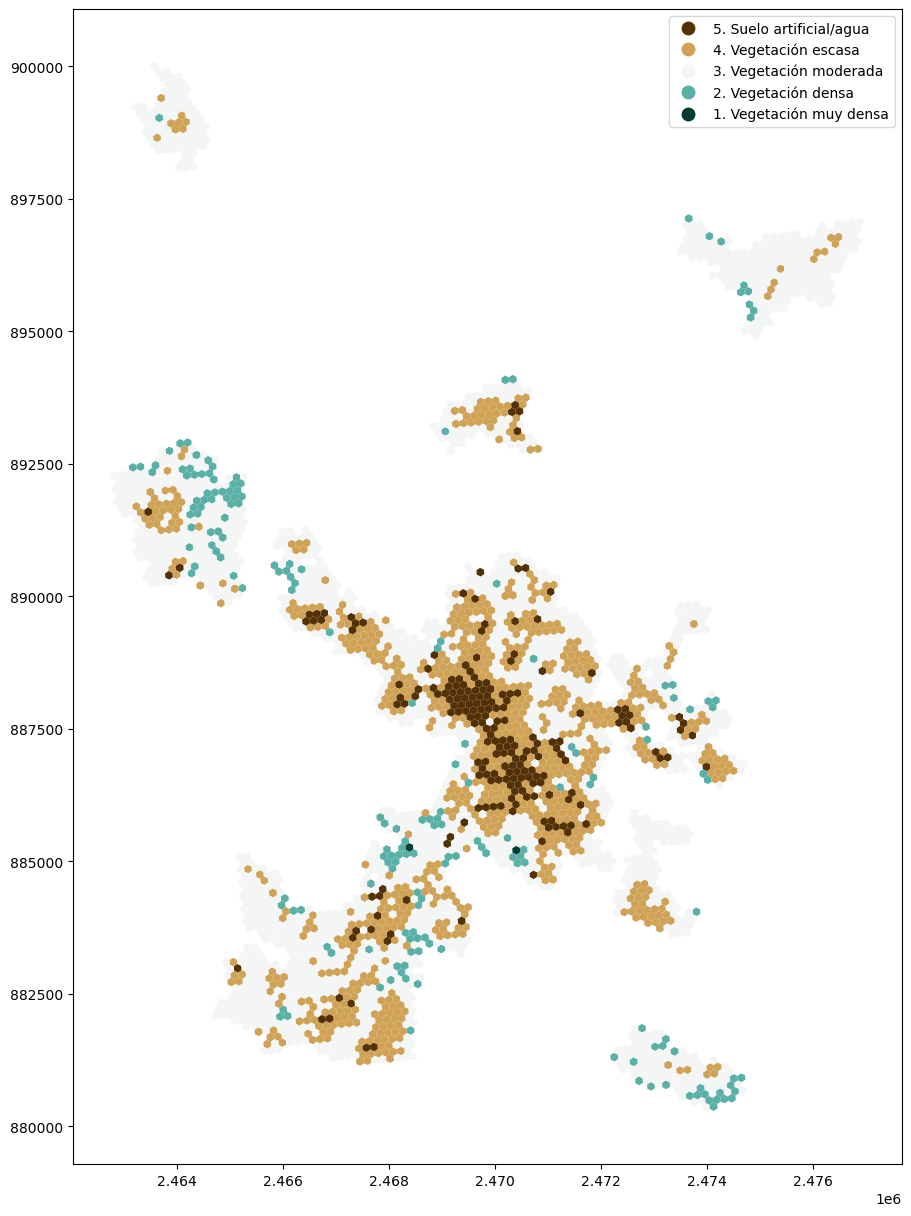

In [9]:
fig,ax = plt.subplots(figsize=(15,15))
hex_kepler.plot('Rango de vegetación',
                cmap='BrBG',
                legend=True,
                ax=ax)

### Prueba kepler en limpio [Versión más avanzada]

In [10]:
# 4.0 --- --- --- KEPLER CONFIGURATION --- --- ---
# Append dummy rows to gdf (They don't show since nothing is assigned to 'geometry' col,
# but ensures that all categories are present in each city (And therefore, the simbology doesn't vary from city to city)
if slope_data:
    dummy_rows = pd.DataFrame({main_col: categories,
                               slope_col: [None]*5})
else:
    dummy_rows = pd.DataFrame({main_col: categories})

dummy_gdf = gpd.GeoDataFrame(dummy_rows, geometry=[None]*5, crs=hex_kepler.crs)
# Turn main_col into categorical ordered column in order to keep categorical order after concatenation
dummy_gdf[main_col] = pd.Categorical(dummy_gdf[main_col], categories=categories, ordered=True)
hex_kepler_complete = pd.concat([hex_kepler, dummy_gdf], ignore_index=True)
# Force categorical order
hex_kepler_complete.sort_values(by=main_col, inplace=True)
# Categorical revision
print("CATEGORICAL REVISION:")
print(hex_kepler_complete[main_col].cat.categories)
print(hex_kepler_complete[main_col].unique())

# Kepler not loading if it is projected_crs
if hex_kepler_complete.crs != "EPSG:4326":
    hex_kepler_complete.to_crs("EPSG:4326",inplace=True)
    print(f"Changed {city}'s hex_kepler_complete crs to EPSG:4326.")

# CONFIGURATION
config, config_idx = aup.kepler_config()
# CONFIGURATION - Configure visualized layer
config["config"]["visState"]["layers"][0]["visualChannels"]["colorField"]["name"] = main_col

# CONFIGURATION - Configure the color palette of the visualized layer
# BRBG color palette divided in 5 categories (Vegetation). Browns for lower values, Greens for higher values.
brbg_5 = ["#01665E", #Dark green-blueish
          "#35978F", #Light green-blueish
          "#DFE6E1", #Light gray
          "#BF812D", #Light brown
          "#8C510A"] #Dark brown

# Color palette from gray to green, used in 2023
palette_2023 = ["#004428", # Dark green
                "#1c934f", # Green
                "#add767", # Light green
                "#edf0d8", # Cream
                "#c6c6c6"] # Gray

config["config"]["visState"]["layers"][0]["config"]["visConfig"]["colorRange"] = {
    "name": "BrBG_custom",
    "type": "custom",
    "category": "Custom",
    "colors": palette_2023,
    "reversed": False
}
# CONFIGURATION - Stroke width and color [Final decision: 0.05 white]
stroke=0.05
if dissolve_hexs: #No stroke when dissolving hex because when hovering, a lot of lines get highlighted.
    stroke=0

config["config"]["visState"]["layers"][0]["config"]["visConfig"]["thickness"] = stroke # En el dict. está en 0.5
config["config"]["visState"]["layers"][0]["config"]["visConfig"]["strokeColor"] = [255, 255, 255] # En el dict. está [28, 27, 27]
# Negro --> "#000000" --> [0, 0, 0]
# Blanco --> "#ffffff" --> [255, 255, 255]

# CONFIGURATION - Opacity
opacity = 0.10 # Set 0.10
config["config"]["visState"]["layers"][0]["config"]["visConfig"]["opacity"] = opacity # En la función está en 0.85

# CONFIGURATION - Turning on/off map functionalities
# Turn on geocoder (Search tab)
config["config"]["visState"]["interactionConfig"]["geocoder"]["enabled"] = True
# Stop user from activating manually dual map viewer
config["config"]["splitMaps"] = []
# Force turn on legend
config["config"]["visState"]["legend"] = {"active": True}

# CONFIGURATIONS ALREADY TURNED OFF IN FUNCTION
# Turn off dual map viewer (Already turned off in function)
#config["config"]["mapState"]["isSplit"] = False
# Turn off brush (Already turned off in function)
#config["config"]["visState"]["interactionConfig"]["brush"]["enabled"] = False
# Turn off coordinate (Already turned off in function)
#config["config"]["visState"]["interactionConfig"]["coordinate"]["enabled"] = False

# CONFIGURATION - Configure map starting point
longitude = hex_kepler_complete.dissolve().geometry.centroid.x
latitude = hex_kepler_complete.dissolve().geometry.centroid.y
config["config"]["mapState"]["latitude"] = latitude[0]
config["config"]["mapState"]["longitude"] = longitude[0]

# CONFIGURATION - Configure data when hovering over hex
# Just one layer
#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"]["Análisis de hexágono"] = [main_col,slope_col]
# Two layers
if slope_data:
    config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {
        "Análisis de hexágono": [main_col],
        "Análisis de pendiente": [slope_col]
    }
else:
    config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {"Análisis de hexágono": [main_col]}  

# ADD CONFIGURATION AND DATA TO MAP
map_city = KeplerGl(height=800)
map_city.config = config
if slope_data:
    map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')
    map_city.add_data(hex_kepler_complete, name='Análisis de pendiente')
else:
    map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')

print(f"Finished {city}'s map config.")

# 4.0 --- --- --- SAVE HTML --- --- ---
if test == True:
    file_name = f'NDVI_{city}_{res}_opacity{opacity}_whitestroke{stroke}_8.html'
    map_city.save_to_html(file_name = map_output_dir+f"tests/{file_name}", read_only=False)

NameError: name 'categories' is not defined

### Add title to map editing HTML

### Anterior prueba kepler

In [ ]:
# 4.0 --- --- --- KEPLER CONFIGURATION --- --- ---
# Append dummy rows to gdf (They don't show since nothing is assigned to 'geometry' col,
# but ensures that all categories are present in each city (And therefore, the simbology doesn't vary from city to city)
dummy_rows = pd.DataFrame({main_col: ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal'],
                           slope_col: [None]*5})
dummy_gdf = gpd.GeoDataFrame(dummy_rows, geometry=[None]*5, crs=hex_kepler.crs)
hex_kepler_complete = pd.concat([hex_kepler, dummy_gdf], ignore_index=True)

# Kepler not loading if it is projected_crs
if hex_kepler_complete.crs != "EPSG:4326":
    hex_kepler_complete.to_crs("EPSG:4326",inplace=True)
    print(f"Changed hex_kepler_complete crs to EPSG:4326.")

# CONFIGURATION
config, config_idx = aup.kepler_config()

# CONFIGURATION - Configure visualized layer
config["config"]["visState"]["layers"][0]["visualChannels"]["colorField"]["name"] = main_col

# CONFIGURATION - Configure the color palette of the visualized layer
# BRBG color palette divided in 5 categories (Vegetation). Browns for lower values, Greens for higher values.
brbg_5 = ["#01665E", #Dark green-blueish
          "#35978F", #Light green-blueish
          "#DFE6E1", #Light gray
          "#BF812D", #Light brown
          "#8C510A"] #Dark brown

config["config"]["visState"]["layers"][0]["config"]["visConfig"]["colorRange"] = {
    "name": "BrBG_custom",
    "type": "custom",
    "category": "Custom",
    "colors": brbg_5,
    "reversed": False
}

# CONFIGURATION - Configure ??
#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"][
#    "datos"]= [final_max_column, 'max_escuelas', 'pobtot']
# hex_gdf["d"] = 0

# CONFIGURATION - Configure map starting point
longitude = hex_kepler_complete.dissolve().geometry.centroid.x
latitude = hex_kepler_complete.dissolve().geometry.centroid.y
config["config"]["mapState"]["latitude"] = latitude[0]
config["config"]["mapState"]["longitude"] = longitude[0]

# CONFIGURATION - Configure ??
# session = boto3.Session(profile_name="observatorio")
# dev_s3_client = session.client("s3")
# map_city = KeplerGl(height=800, data={"Análisis de ciudad": hex_kepler}, config=config_idx)

no_agregar_pendiente = """
# CONFIGURATION - Second layer (Slope) configuration [ANÁLISIS DE PENDIENTE]
# Duplicate previous configuration
slope_layer = copy.deepcopy(config["config"]["visState"]["layers"][0])
# Set new ID and label
slope_layer["id"] = "slope_layer"
slope_layer["config"]["label"] = "Pendiente de vegetación"
slope_layer["config"]["dataId"] = "Análisis de pendiente"
# Configure chanels (Visualized layer and color palette)
slope_layer["visualChannels"]["colorField"] = {"name": slope_col, "type": "real"}
slope_layer["visualChannels"]["colorScale"] = "diverging"
slope_layer["config"]["visConfig"]["colorRange"] = {
    "name": "GreenWhiteRed",
    "type": "custom",
    "category": "Custom",
    "colors": ["#1a9850", "#91cf60", "#d9ef8b", "#ffffbf", "#fdae61", "#d73027", "#a50026"],
    "reversed": False
}
# Add back to congig
config["config"]["visState"]["layers"].append(slope_layer) """

# CONFIGURATION - Configure data when hovering over hex
# Just one layer
#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"]["Análisis de hexágono"] = [main_col,slope_col]
# Two layers
config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {
    "Análisis de hexágono": [main_col],
    "Análisis de pendiente": [slope_col]
}

# ADD CONFIGURATION AND DATA TO MAP
map_city = KeplerGl(height=800)
map_city.config = config
map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')

no_agregar_pendiente = """
map_city.add_data(hex_kepler_complete, name="Análisis de pendiente")
"""
map_city